In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist

In [3]:
dataset = int(input('0:mnist, 1:fmnist, 2:cifar10 -> '))

(x_train, y_train), (x_test, y_test) = [mnist, fashion_mnist, cifar10][dataset].load_data()

test_image = x_train[0]
print(test_image.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

0:mnist, 1:fmnist, 2:cifar10 -> 2
(32, 32, 3)
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


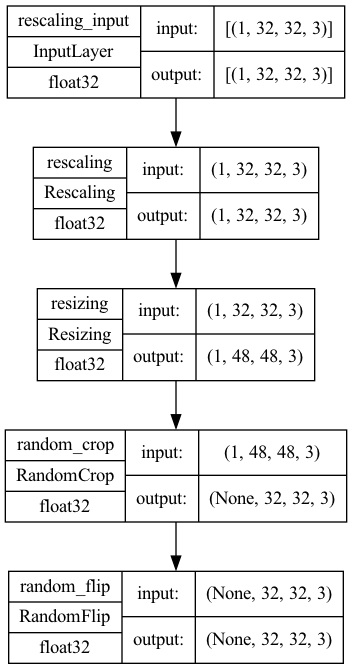

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, Resizing, RandomCrop, RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np

model = Sequential([Rescaling(1/255.),
                    
                    Resizing(int(test_image.shape[0]*1.5), 
                             int(test_image.shape[1]*1.5)),                   
                    
                    RandomCrop(test_image.shape[0], test_image.shape[0]),
                    
                    RandomFlip('horizontal')])
                    # RandomRotation(np.random.randint(0, 360))])

Model.build(model, (1, test_image.shape[0], test_image.shape[1], 3))

plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

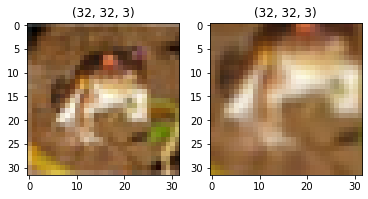

In [9]:
# new_shape = model(test_image).shape[1:-1]
# new = tf.reshape(model(x_train[:1]), new_shape)

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(test_image)
ax2.imshow(model(test_image))
ax1.set_title(test_image.shape)
ax2.set_title(model(test_image).shape);

#### 절차

##### 1. 이미지 증식 후 저장 (레이블 포함)

In [10]:
x_train1 = model(x_train)

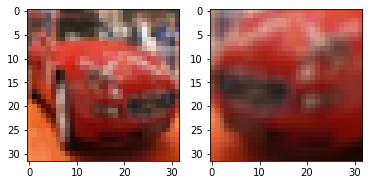

In [12]:
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(x_train[5])
ax2.imshow(x_train1[5]);

In [13]:
x_train_all = np.concatenate([x_train, x_train1], axis=0)
y_train_all = np.concatenate([y_train, y_train], axis=0)
print(x_train.shape, x_train_all.shape)
print(y_train.shape, y_train_all.shape)

(50000, 32, 32, 3) (100000, 32, 32, 3)
(50000, 1) (100000, 1)


In [20]:
# Augmentation + conv

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization

def build_cnn():
    model = Sequential()
    model.add(Conv2D(16, 3, activation='relu', input_shape=[32,32,3]))
    model.add(MaxPool2D(pool_size=(2,2), strides=2))
    model.add(Conv2D(32, 3, activation='relu'))
#     model.add(MaxPool2D(pool_size=(2,2), strides=2))
#     model.add(Conv2D(64, 3, activation='relu'))
    model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

##### 2. original train only

In [22]:
model1 = build_cnn()

In [23]:
# callback 기능 포함 학습 실행
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model1.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

model_checkpoint_callback = ModelCheckpoint(
    filepath='./tmp/checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
hist = model1.fit(x_train, y_train, epochs=5, 
                  batch_size=128, validation_split=0.1, 
                  callbacks=[early_stopping, model_checkpoint_callback])

checkpoint_filepath = model_checkpoint_callback.filepath

# The model weights (that are considered the best) are loaded into the model.
model1.load_weights(checkpoint_filepath)

Epoch 1/5
352/352 [==============================] - 6s 16ms/step - loss: 3.7133 - acc: 0.2804 - val_loss: 1.6942 - val_acc: 0.4024
Epoch 2/5
352/352 [==============================] - 6s 17ms/step - loss: 1.5704 - acc: 0.4505 - val_loss: 1.5402 - val_acc: 0.4622
Epoch 3/5
352/352 [==============================] - 6s 17ms/step - loss: 1.3966 - acc: 0.5106 - val_loss: 1.4695 - val_acc: 0.4916
Epoch 4/5
352/352 [==============================] - 6s 18ms/step - loss: 1.2950 - acc: 0.5450 - val_loss: 1.4302 - val_acc: 0.5006
Epoch 5/5
352/352 [==============================] - 7s 19ms/step - loss: 1.2155 - acc: 0.5706 - val_loss: 1.5000 - val_acc: 0.4910


In [24]:
model1.evaluate(x_test, y_test) # 50.45 accuracy

313/313 [==============================] - 2s 7ms/step - loss: 1.4246 - acc: 0.5045


[1.4245519638061523, 0.5044999718666077]

##### 3. training with augmented dataset

In [28]:
model2 = build_cnn()

model2.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

hist2 = model2.fit(x_train_all, y_train_all, epochs=5, 
                  batch_size=128, validation_split=0.1,) 
#                  callbacks=[early_stopping, model_checkpoint_callback])

#checkpoint_filepath = model_checkpoint_callback.filepath

# The model weights (that are considered the best) are loaded into the model.
#model2.load_weights(checkpoint_filepath)

Epoch 1/5
704/704 [==============================] - 14s 20ms/step - loss: 3.1677 - acc: 0.1613 - val_loss: 2.0915 - val_acc: 0.2225
Epoch 2/5
704/704 [==============================] - 14s 20ms/step - loss: 2.0649 - acc: 0.2527 - val_loss: 1.9704 - val_acc: 0.2819
Epoch 3/5
704/704 [==============================] - 14s 20ms/step - loss: 1.9781 - acc: 0.2846 - val_loss: 1.8578 - val_acc: 0.3196
Epoch 4/5
704/704 [==============================] - 14s 20ms/step - loss: 1.8766 - acc: 0.3185 - val_loss: 1.8300 - val_acc: 0.3323
Epoch 5/5
704/704 [==============================] - 14s 20ms/step - loss: 1.7853 - acc: 0.3517 - val_loss: 1.7496 - val_acc: 0.3562


In [29]:
model2.evaluate(x_test, y_test) # 50.45 accuracy

313/313 [==============================] - 3s 9ms/step - loss: 1.7501 - acc: 0.3688


[1.7501217126846313, 0.36880001425743103]